# ✈️ Forecasting Air Passengers Using Amazon Chronos2
This notebook demonstrates how to use **[Amazon Chronos: Pretrained Models for Time Series Forecasting](https://github.com/amazon-science/chronos-forecasting)**, a foundation model for probabilistic time-series forecasting, on the classic **Air Passengers** dataset.

You will learn how to:
- Load and visualize the dataset
- Format data for Chronos2
- Generate forecasts with uncertainty intervals
- Plot historical data, ground truth, and forecast


### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Load dataset

In [2]:
df = pd.read_csv("data/AirPassengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')
df.columns = ['Passengers']
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Visualize the Time Series

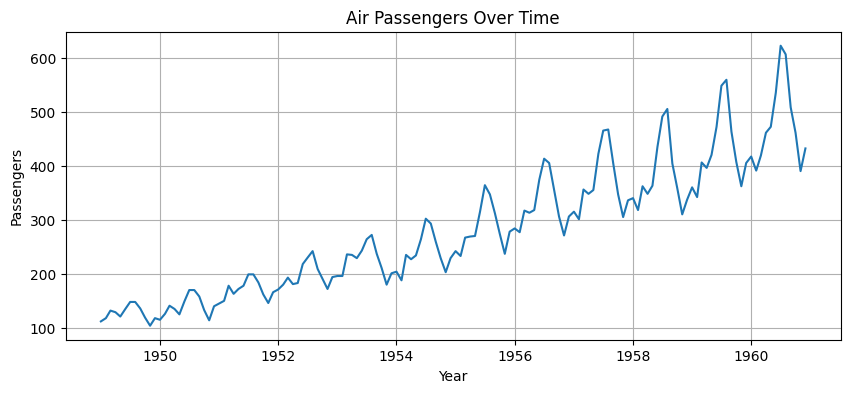

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df['Passengers'])
plt.title("Air Passengers Over Time")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

### Convert Data to Chronos2 Format

In [4]:
df_chronos = df.copy().reset_index()
df_chronos['id'] = 'air_passengers'
df_chronos = df_chronos.rename(columns={'Month':'timestamp', 'Passengers':'target'})
df_chronos.head()

,timestamp,target,id
0,1949-01-01,112,air_passengers
1,1949-02-01,118,air_passengers
2,1949-03-01,132,air_passengers
3,1949-04-01,129,air_passengers
4,1949-05-01,121,air_passengers


### Train–Test Split

In [5]:
train_df = df_chronos.iloc[:-12]
test_df = df_chronos.iloc[-12:]
future_df = test_df.drop(columns=['target'])

train_df.tail(), test_df.head()

(     timestamp  target              id
 127 1959-08-01     559  air_passengers
 128 1959-09-01     463  air_passengers
 129 1959-10-01     407  air_passengers
 130 1959-11-01     362  air_passengers
 131 1959-12-01     405  air_passengers,
      timestamp  target              id
 132 1960-01-01     417  air_passengers
 133 1960-02-01     391  air_passengers
 134 1960-03-01     419  air_passengers
 135 1960-04-01     461  air_passengers
 136 1960-05-01     472  air_passengers)

## Load Chronos2 Model and Forecast
Requires:
```
pip install chronos-forecasting
pip install 'pandas[pyarrow]'
```
GPU recommended.

In [6]:
from chronos import Chronos2Pipeline

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cpu")

pred_df = pipeline.predict_df(
    train_df,
    future_df=future_df,
    prediction_length=12,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="id",
    timestamp_column="timestamp",
    target="target"
)

pred_df.head()

,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,air_passengers,1960-01-01,target,415.702820,399.586670,415.702820,432.993896
1,air_passengers,1960-02-01,target,403.641571,386.408142,403.641571,420.039612
2,air_passengers,1960-03-01,target,475.576630,452.103577,475.576630,494.148956
3,air_passengers,1960-04-01,target,454.391052,437.371399,454.391052,473.454132
4,air_passengers,1960-05-01,target,463.572662,443.220612,463.572662,483.998840


### Plot Forecast vs Ground Truth

Chronos2 RMSE: 19.614619723174997


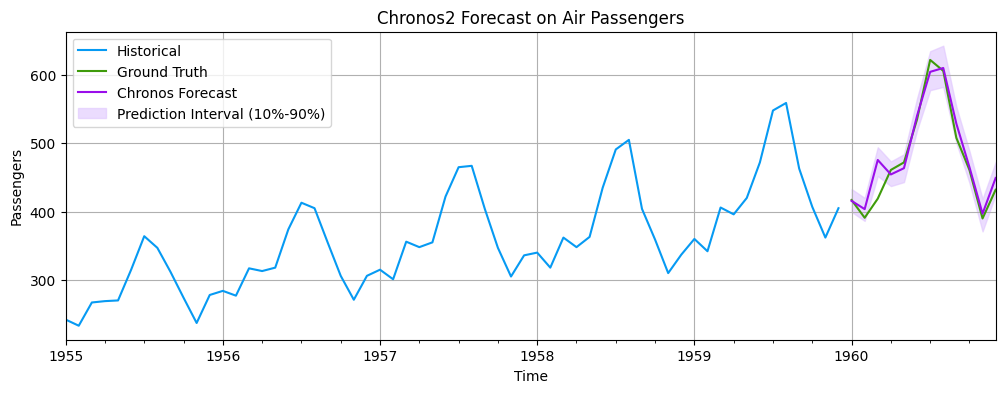

In [7]:
ts_context = train_df.set_index("timestamp")["target"].tail(60)
ts_gt = test_df.set_index("timestamp")["target"]
ts_pred = pred_df.set_index("timestamp")
ts_true = test_df.set_index("timestamp")["target"]

plt.figure(figsize=(12,4))
ts_context.plot(label="Historical", color="xkcd:azure")
ts_gt.plot(label="Ground Truth", color="xkcd:grass green")
ts_pred["predictions"].plot(label="Chronos Forecast", color="xkcd:violet")

# ---- FIXED RMSE CALCULATION ----
rmse_chronos = np.sqrt(mean_squared_error(ts_true, ts_pred["predictions"]))
print("Chronos2 RMSE:", rmse_chronos)

# Prediction interval fill
plt.fill_between(
    ts_pred.index,
    ts_pred["0.1"],
    ts_pred["0.9"],
    alpha=0.6,
    color="xkcd:light lavender",
    label="Prediction Interval (10%-90%)"
)

plt.title("Chronos2 Forecast on Air Passengers")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()
